## IMPORT LIBRARIES

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

from nltk.translate.bleu_score import corpus_bleu

## SET DIRECTORIES

In [2]:
INPUT_DIR = "C:\\Users\\bhudi\\Downloads\\fkr8k"
OUTPUT_DIR = 'C:\\Users\\bhudi\\Downloads\\fkr8k\\working'

## IMPORT PRE-TRAINED MODEL

In [3]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## EXTRACT IMAGE FEATURES

In [4]:
image_features = {}

img_dir = os.path.join(INPUT_DIR, 'Images')

for img_name in tqdm(os.listdir(img_dir)):

    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)

    image_feature = model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]

    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [6]:
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

## GET CAPTIONS

In [7]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [8]:
image_to_captions_mapping = defaultdict(list)
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens

    image_id = image_id.split('.')[0]

    caption = " ".join(captions)

    image_to_captions_mapping[image_id].append(caption)

total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [10]:
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [11]:
clean(image_to_captions_mapping)

In [12]:
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## TOKENIZATION

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [14]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [15]:
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


## TRAIN TEST SPLIT

In [16]:
image_ids = list(image_to_captions_mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

## DATA GENERATOR

In [17]:
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []

    batch_count = 0

    while True:
        for image_id in data_keys: 

            captions = image_to_captions_mapping[image_id]

            for caption in captions:

                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
 
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1_batch.append(features[image_id][0]) 
                    X2_batch.append(in_seq) 
                    y_batch.append(out_seq)  

                    batch_count += 1

                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

## MODEL CREATION

In [18]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

attention_scores = Activation('softmax')(attention)

attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

context_vector = tf.reduce_sum(attention_context, axis=1)

decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

## MODEL TRAINING

In [19]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
epochs = 75
batch_size = 32

steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=2,callbacks=[early_stopping])

Epoch 1/75
228/228 - 86s - loss: 6.4567 - val_loss: 6.5351 - 86s/epoch - 378ms/step
Epoch 2/75
228/228 - 71s - loss: 5.2886 - val_loss: 6.4082 - 71s/epoch - 313ms/step
Epoch 3/75
228/228 - 72s - loss: 4.8490 - val_loss: 6.4632 - 72s/epoch - 317ms/step
Epoch 4/75
228/228 - 73s - loss: 4.5622 - val_loss: 6.6527 - 73s/epoch - 320ms/step
Epoch 5/75
228/228 - 73s - loss: 4.2770 - val_loss: 6.7761 - 73s/epoch - 319ms/step
Epoch 6/75
228/228 - 73s - loss: 3.9676 - val_loss: 6.9116 - 73s/epoch - 318ms/step
Epoch 7/75
228/228 - 71s - loss: 3.6465 - val_loss: 7.0108 - 71s/epoch - 310ms/step
Epoch 8/75
228/228 - 72s - loss: 3.3671 - val_loss: 7.0513 - 72s/epoch - 315ms/step
Epoch 9/75
228/228 - 71s - loss: 3.2219 - val_loss: 6.7994 - 71s/epoch - 313ms/step
Epoch 10/75
228/228 - 75s - loss: 3.0133 - val_loss: 7.2605 - 75s/epoch - 328ms/step
Epoch 11/75
228/228 - 84s - loss: 2.7800 - val_loss: 6.8992 - 84s/epoch - 370ms/step
Epoch 12/75
228/228 - 90s - loss: 2.6057 - val_loss: 6.9699 - 90s/epoch - 

In [21]:
model.save(OUTPUT_DIR+'/mymodel.h5')

## OUTPUT AND EVALUATION

In [22]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [23]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = 'startseq'

    for _ in range(max_caption_length):

        sequence = tokenizer.texts_to_sequences([caption])[0]

        sequence = pad_sequences([sequence], maxlen=max_caption_length)
 
        yhat = model.predict([image_features, sequence], verbose=0)

        predicted_index = np.argmax(yhat)

        predicted_word = get_word_from_index(predicted_index, tokenizer)

        caption += " " + predicted_word

        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [24]:
actual_captions_list = []
predicted_captions_list = []

for key in tqdm(test):
    actual_captions = image_to_captions_mapping[key]

    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    actual_captions_words = [caption.split() for caption in actual_captions]

    predicted_caption_words = predicted_caption.split()

    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

print('BLEU SCORE:')
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU SCORE:
BLEU-1: 0.409889
BLEU-2: 0.177433


In [26]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    plt.imshow(image)
    captions = image_to_captions_mapping[image_id]    
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('PREDICTION:',y_pred)
    

PREDICTION: startseq man looks at framed pictures in the snow next to trees endseq


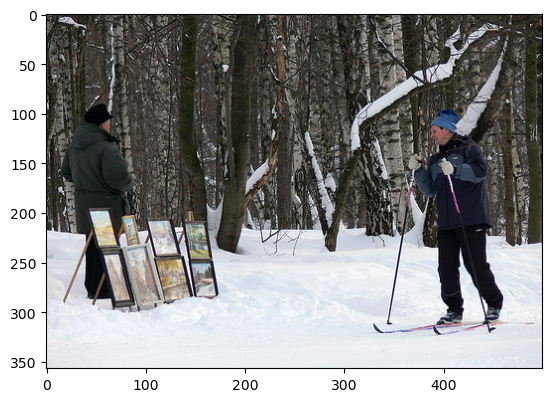

In [27]:
generate_caption("101669240_b2d3e7f17b.jpg")

PREDICTION: startseq two dogs of different breeds looking at each other on the road endseq


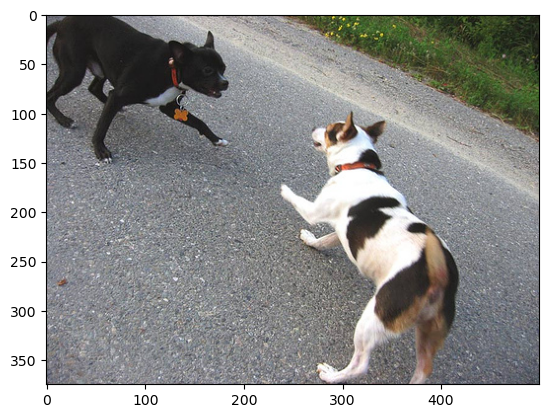

In [28]:
generate_caption("1001773457_577c3a7d70.jpg")